# Background

This series of tutorials are based on the is based on the GMDSI Open Loop Low Temperature Geothermal System (non-python) tutorials, which can be found here: https://gmdsi.org/blog/gwe_slideshow/

The purpose of these `notebooks` is to demonstrate how to:

 - go about programatically settting up a `PEST++` interface with an unstructured grid model;
 - parameterize parameter fields with non-stationary geostatistics informed by conceptual knowledge; and
 - undertake surrogate-based data assimilation and predictive uncertainty analysis using data space inversion

In [1]:
import flopy
import pyemu
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import herebedragons as hbd

# The Model

First we introduce the model.

The image below is extracted from the [slideshow](https://gmdsi.org/wp-content/uploads/2025/04/gwf_gwe_model.pptx) file that accompanies the original GMDSI tutorial. It shows the model grid and boundary conditions.

The model represents a shallow, channelized alluviual deposits close to a river (North boundary), which pinch out where bedrock outcrops to the South. The system is represented using a single layer model. North boundary is simulated using the RIV package. East and Western boundaries are specified as general head boundaries. 

The model is used to simulate a (past) historical period and a (future) forecast period. In the forecast period an open loop shalow geothermal system is active. The flow model is simulated as steady-state for both historical and forecast periods. The heat transport model is transient. In the foreacst period it simulates periods of seasonaly varying injection temperature. The background temperature is 16&deg;C.


![image info](./data/Pmodel.png)


Model files are stored in the `model` directory. Load them up to take a look:

In [2]:
ws = "model"

Run the next cell to call a helper function we have prepared, just to amke sure the correct `modflow6` and `pest` executables are in the model filder:

In [3]:
hbd.get_bins(ws)

'bin/mac'

## Run the model once
Unusualy for our tutorials, this model actualy takes a while to run. We need to run it once to make sure all the model output files are generated.

### Warning: this might take a few minutes. 
For context, it takes ~5min on a MacBook Pro.


In [4]:
pyemu.os_utils.run(f"mf6", cwd=ws)

./mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.7.0.dev3 (preliminary) 10/16/2025
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 16 2025 14:05:53 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from 

## Load the model 

Use `flopy`, load the model and take a look around:

In [5]:
sim = flopy.mf6.MFSimulation.load(sim_ws=ws, verbosity_level=0)

# the flow model 
gwf = sim.get_model("gwf")

# the groundwater energy model
gwe = sim.get_model("gwe")

In [6]:
gwf.get_package_list()

['DISV',
 'IC',
 'NPF',
 'CHD',
 'RIV_OBS',
 'RIV',
 'RCH',
 'WELL_INJECT',
 'WELL_EXTRACT',
 'OC',
 'OBS']

In [7]:
gwe.get_package_list()

['DISV', 'OBS', 'OC', 'SSM_SPC', 'SSM', 'EST', 'CND', 'ADV', 'IC']

In [8]:
k = gwf.npf.k.get_data()
k

array([[2.58e-04, 2.57e-04, 2.60e-04, ..., 1.05e-04, 3.80e-05, 1.32e-05]],
      shape=(1, 13417))

We only track two stress periods for flow (history and future), both are steady state.

In [9]:
heads = gwf.output.head().get_alldata()
heads.shape

(2, 1, 1, 13417)

We track all stress periods for the energy model. All are transient.

In [10]:
temp = gwe.output.temperature().get_alldata()
temp.shape

(61, 1, 1, 13417)

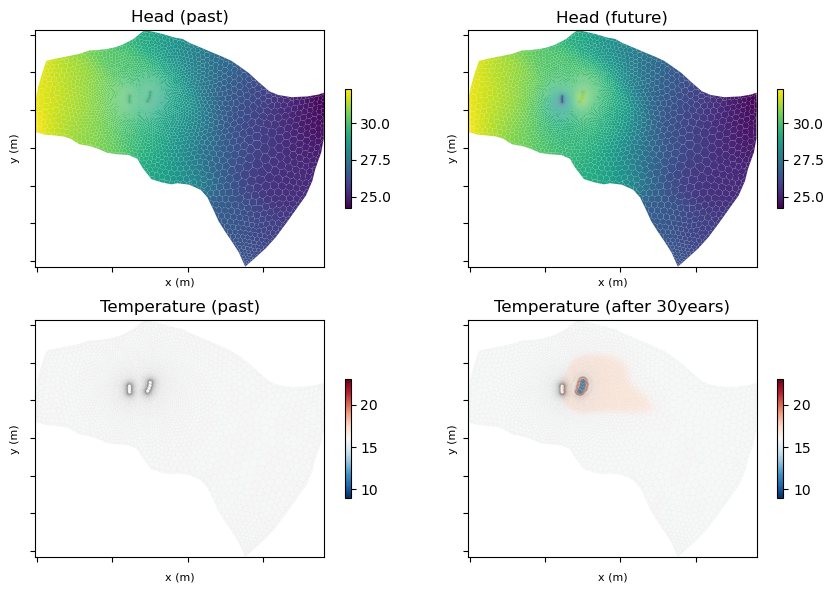

In [11]:
fig,axs = plt.subplots(2,2,figsize=(9,6),sharex=True,sharey=True)

ax = axs[0,0]
ax.set_aspect('equal')
ax.set_title("Head (past)")
pm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
pa = pm.plot_array(heads[0,:,:,:], cmap="viridis")
plt.colorbar(pa, ax=ax,shrink=0.5)
ax = axs[0,1]

a =  heads[-1,:,:,:]

ax.set_aspect('equal')
ax.set_title("Head (future)")
pm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
pa = pm.plot_array(a, cmap="viridis")
plt.colorbar(pa, ax=ax,shrink=0.5)


ax = axs[1,0]
ax.set_aspect('equal')
ax.set_title("Temperature (past)")
pm = flopy.plot.PlotMapView(model=gwe, ax=ax, layer=0)
pm.plot_grid(lw=0.1,alpha=0.1)
pa = pm.plot_array(temp[0,:,:,:], cmap="RdBu_r", vmin=9,vmax=16+7)
plt.colorbar(pa, ax=ax,shrink=0.5)

ax = axs[1,1]
a = temp[-1,:,:,:]       
ax.set_aspect('equal')
ax.set_title("Temperature (after 30years)")
pm = flopy.plot.PlotMapView(model=gwe, ax=ax, layer=0,)
pm.plot_grid(lw=0.1,alpha=0.1)
pa = pm.plot_array(a, cmap="RdBu_r", vmin=16-7,vmax=16+7)
plt.colorbar(pa, ax=ax,shrink=0.5) 

for ax in axs.flatten():
    ax.set_xlabel("x (m)",size=8)
    ax.set_ylabel("y (m)",size=8)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()
plt.show()

A look at everyones favourite paramter...

<Axes: title={'center': 'k'}>

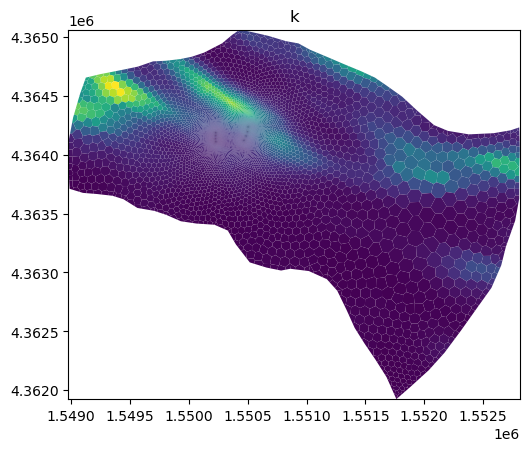

In [12]:
gwf.npf.k.plot()

# Conceptual model

A key aspect of this case is that, we have some conceptual knowledge about the geostatistics of the hydraulic conducvitiy. 

We sat down with the project geologist and translated their conceptual knowledge on "how K is expected to vary in space" into a set of hyperparameters assigned to pilot points. These include:

 - mean K value
 - variance
 - spatial correlatin length
 - anisotropy ratio
 - bearing

Let's load these data and take a look:

In [13]:
df = pd.read_csv(os.path.join("data","conceptual_kh.pts"), sep=r'\s+', index_col=0)
df.rename(columns={'easting':"x","northing":"y"}, inplace=True)
df.head()

,x,y,mean,var,a,hanis,bearing
point,,,,,,,
1,1.549167e+06,4.364592e+06,0.00015,0.15,600.0,3.0,120.0
2,1.549794e+06,4.364694e+06,0.00015,0.15,600.0,3.0,130.0
3,1.550443e+06,4.364913e+06,0.00015,0.15,600.0,3.0,130.0
4,1.551101e+06,4.364781e+06,0.00015,0.15,600.0,3.0,113.0
5,1.551591e+06,4.364520e+06,0.00015,0.15,600.0,3.0,113.0


In the plot below, at each pilot point, we have plotted the mean K value (color of the point), the line of bearing, the length of which reflects the correlation length (longer lines means greater correlation), and the perpendicular line showing the transversal bearing&correlation length.

Thi sinformation will be used later to generate random feilds of K which respect these patterns of heterogeinty. Strap in!

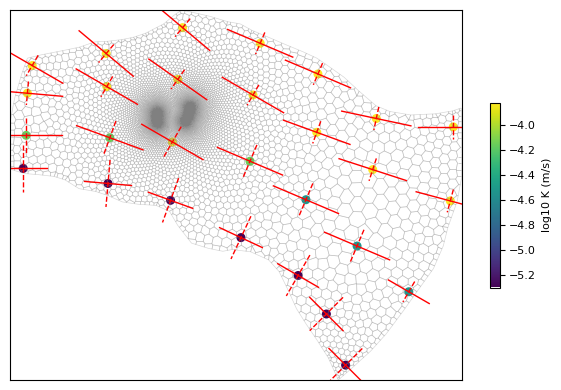

In [14]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.set_aspect('equal')
pm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
pm.plot_grid(lw=.5,alpha=0.3,);

# plot scatter of kh points
sc = ax.scatter(df.x,df.y,c=np.log10(df['mean']),s=30,cmap="viridis")
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label("log10 K (m/s)",size=8)
cbar.ax.tick_params(labelsize=8)

# plot lines at each point, with length "a" and bearing "bearing" in df
for idx, row in df.iterrows():
    bearing = row.bearing
    a = row.a
    x0 = row.x - a * np.cos(np.radians(90 - bearing))/2
    y0 = row.y - a * np.sin(np.radians(90 - bearing))/2
    # convert bearing to radians
    theta = np.radians(90 - bearing)
    x1 = x0 + a * np.cos(theta)
    y1 = y0 + a * np.sin(theta)
    ax.plot([x0, x1], [y0, y1], color='red', linewidth=1)

    # plot anisotropy direction as a dashed line
    aniso_bearing = bearing + 90
    a_anis = a / row.hanis
    x0_aniso = row.x - a_anis * np.cos(np.radians(90 - aniso_bearing))/2
    y0_aniso = row.y - a_anis * np.sin(np.radians(90 - aniso_bearing))/2
    x1_aniso = x0_aniso + a_anis * np.cos(np.radians(90 - aniso_bearing))
    y1_aniso = y0_aniso + a_anis * np.sin(np.radians(90 - aniso_bearing))
    ax.plot([x0_aniso, x1_aniso], [y0_aniso, y1_aniso], color='r', linewidth=1, linestyle='--')  


ax.set_xticklabels([])
ax.set_yticklabels([]);
ax.set_xticks([]);
ax.set_yticks([]);

fig.tight_layout();